In [ ]:
! pip install transformers
! pip install seqeval

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange


In [2]:
# 打开文件
with open("2023-data/train.txt", "r") as file:
    # 读取文件内容
    lines = file.readlines()
# 分割每行并创建 DataFrame
train = [line.strip().split("   ") for line in lines]
train = pd.DataFrame(train, columns=["word", "label"]).fillna('')

with open("2023-data/dev.txt", "r") as file:
    # 读取文件内容
    lines = file.readlines()
# 分割每行并创建 DataFrame
devel = [line.strip().split("   ") for line in lines]
devel = pd.DataFrame(devel, columns=["word", "label"]).fillna('')

with open("2023-data/test.txt", "r") as file:
    # 读取文件内容
    lines = file.readlines()
# 分割每行并创建 DataFrame
test = [line.strip().split("   ") for line in lines]
test = pd.DataFrame(test, columns=["word", "label"]).fillna('')
train

,word,label
0,[Implantation,O
1,of,O
2,newborn,O
3,mice,O
4,skin,O
...,...,...
79287,and,O
79288,Wnt/beta-catenin,O
79289,signaling,O
79290,.,O


In [3]:
def vet_frases(dataframe):
  sentences = []
  sentences_aux = []
  labels = []
  labels_aux = []
  for word, label in zip(dataframe.word.values, dataframe.label.values):
    if (word == ''):
        continue
    sentences_aux.append(word)
    labels_aux.append(label)
    if (word == '.'):
      sentences.append(sentences_aux)
      labels.append(labels_aux)

      sentences_aux = []
      labels_aux = []
  return sentences, labels

In [4]:
train_sentences, train_labels = vet_frases(train)
print(train_sentences[0])
print(train_labels[0])

['[Implantation', 'of', 'newborn', 'mice', 'skin', 'cells', 'with', 'chamber', 'method', 'to', 'construct', 'a', 'model', 'of', 'hair', 'follicle', 'development]', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O']


In [33]:
test_sentences, test_labels = vet_frases(test)
print(test_sentences[0])
print(test_labels[0])

['Induction', 'of', 'hair', 'follicle', 'neogenesis', 'with', 'cultured', 'mouse', 'dermal', 'papilla', 'cells', 'in', 'de', 'novo', 'regenerated', 'skin', 'tissues', '.']
['O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [6]:
devel_sentences, devel_labels = vet_frases(devel)
print(devel_sentences[0])
print(devel_labels[0])

['Reflectance', 'spectroscopy', 'for', 'noninvasive', 'evaluation', 'of', 'hair', 'follicle', 'stage', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O']


In [34]:
tag_values = list(set(train["label"].values))
tag_values.append("PAD")
tag_values = [x for x in tag_values if x]
print(sorted(tag_values))
tag2idx = {t: i for i, t in enumerate(tag_values)}

['B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'PAD']


In [35]:
print(len(tag_values))

4


In [36]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

torch.__version__

'1.7.1'

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [38]:
torch.cuda.get_device_name(0)

'NVIDIA TITAN Xp'

In [39]:
tokenizer = BertTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed', do_lower_case=False)

In [40]:
MAX_LEN = 75
bs = 3

In [41]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []
    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [42]:

train_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sentences, train_labels)
]
test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sentences, test_labels)
]
devel_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(devel_sentences, devel_labels)
]


In [43]:
print(test_tokenized_texts_and_labels[0])

(['In', '##duction', 'of', 'hair', 'f', '##oll', '##icle', 'neo', '##genesis', 'with', 'culture', '##d', 'mouse', 'der', '##mal', 'p', '##ap', '##illa', 'cells', 'in', 'de', 'no', '##vo', 're', '##generate', '##d', 'skin', 'tissues', '.'], ['O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


In [45]:
train_tokenized_texts = [token_label_pair[0] for token_label_pair in train_tokenized_texts_and_labels]
train_labels = [token_label_pair[1] for token_label_pair in train_tokenized_texts_and_labels]
test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]
devel_tokenized_texts = [token_label_pair[0] for token_label_pair in devel_tokenized_texts_and_labels]
devel_labels = [token_label_pair[1] for token_label_pair in devel_tokenized_texts_and_labels]

In [46]:
print(test_tokenized_texts[0])

['In', '##duction', 'of', 'hair', 'f', '##oll', '##icle', 'neo', '##genesis', 'with', 'culture', '##d', 'mouse', 'der', '##mal', 'p', '##ap', '##illa', 'cells', 'in', 'de', 'no', '##vo', 're', '##generate', '##d', 'skin', 'tissues', '.']


In [47]:
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
devel_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in devel_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [48]:
train_input_ids[0]

array([  164,   146,  8223,  9180,  1891,  1104, 24820, 14105,  2241,
        3652,  1114,  5383,  3442,  1106,  9417,   170,  2235,  1104,
        1716,   175, 12666, 26726,  1718,   166,   119,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [49]:
train_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
devel_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in devel_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [50]:
train_tags[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

In [51]:
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]
devel_attention_masks = [[float(i != 0.0) for i in ii] for ii in devel_input_ids]

In [52]:
train_attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [29]:
tr_inputs, val_inputs, tr_tags, val_tags, tr_masks, val_masks = shuffle(train_input_ids, test_input_ids, train_tags, test_tags, train_attention_masks, test_attention_masks, random_state=2020)
devel_inputs, devel_tags, devel_masks = shuffle(devel_input_ids, devel_tags, devel_attention_masks, random_state=2020)

In [30]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
devel_inputs = torch.tensor(devel_inputs)
devel_tags = torch.tensor(devel_tags)
devel_masks = torch.tensor(devel_masks)

In [31]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

devel_data = TensorDataset(devel_inputs, devel_masks, devel_tags)
devel_sampler = SequentialSampler(devel_data)
devel_dataloader = DataLoader(devel_data, sampler=devel_sampler, batch_size=bs)


In [32]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.29.2'

In [105]:
model = BertForTokenClassification.from_pretrained(
    "monologg/biobert_v1.1_pubmed",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at monologg/biobert_v1.1_pubmed were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [106]:
model.cuda();

In [107]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


/home/zhangtao/anaconda3/envs/env3.7/lib/python3.7/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [108]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [109]:
from seqeval.metrics import f1_score, accuracy_score


In [110]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
validation_accuracy, validation_f1 = [], []
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print()
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    validation_accuracy.append(accuracy_score(pred_tags, valid_tags))
    validation_f1.append(f1_score(pred_tags, valid_tags))


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


Average train loss: 0.06085126216544623
Validation loss: 0.023141811269956437
Validation Accuracy: 0.9850344781638296
Validation F1-Score: 0.8424527358207462



Epoch:  33%|███▎      | 1/3 [01:49<03:39, 109.83s/it]


Average train loss: 0.021747177565480013
Validation loss: 0.011668945245960011
Validation Accuracy: 0.9922299210500016
Validation F1-Score: 0.9256750310084917



Epoch:  67%|██████▋   | 2/3 [03:37<01:48, 108.81s/it]


Average train loss: 0.011563969261205233
Validation loss: 0.0064611335621372334
Validation Accuracy: 0.9960691562010726
Validation F1-Score: 0.959732824427481



Epoch: 100%|██████████| 3/3 [05:27<00:00, 109.04s/it]


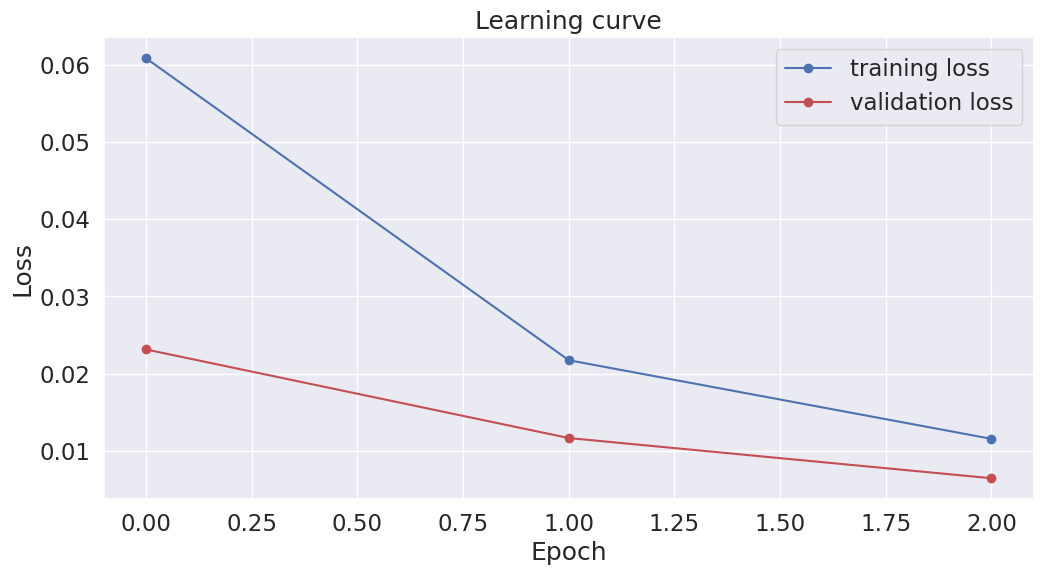

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


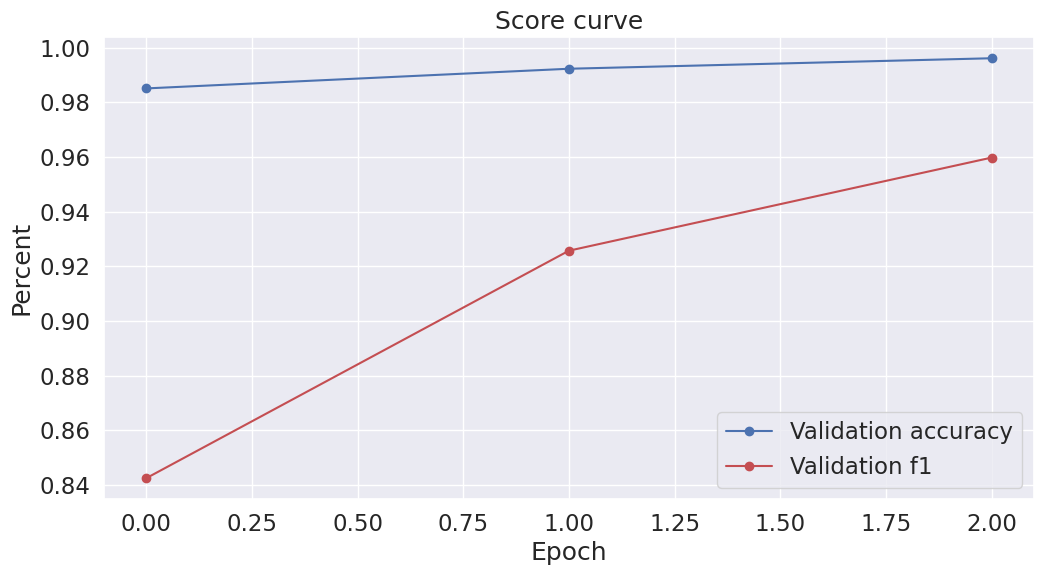

In [112]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(validation_accuracy, 'b-o', label="Validation accuracy")
plt.plot(validation_f1, 'r-o', label="Validation f1")
# Label the plot.
plt.title("Score curve")
plt.xlabel("Epoch")
plt.ylabel("Percent")
plt.legend()

plt.show()


In [148]:
model.eval()
# Reset the validation loss for this epoch.
devel_loss, devel_accuracy = 0, 0
nb_devel_steps, nb_devel_examples = 0, 0
predictions , true_labels = [], []
for batch in devel_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    devel_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

devel_loss = devel_loss / len(devel_dataloader)
print("Devel loss: {}".format(devel_loss))
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                              for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i] != "PAD"]
print("Devel Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
print("Devel F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
print(pred_tags)


Devel loss: 0.03609730118899656
Devel Accuracy: 0.9812326359358168
Devel F1-Score: 0.87042777433354
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'I-FOLLICLE-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [145]:
test_sentence = """Regeneration of "hair follicles" relies on activation of hair follicle stem cells during telogen to anagen transition process in hair cycle. This process is rigorously controlled by intrinsic and environmental factors. 12-o-tetradecanoylphorbol-13-acetate (TPA), a tumor promoter, accelerates reentry of hair follicles into anagen phase. However, it is unclear that how TPA promotes the hair regeneration. In the present study, we topically applied TPA onto the dorsal skin of 2-month-old C57BL/6 female mice to examine the activity of hair follicle stem cells and alteration of signaling pathways during hair regeneration. We found that refractory telogen hair follicles entered anagen prematurely after TPA treatment, with the enhanced proliferation of CD34-positive hair follicle stem cells. Meanwhile, we observed Akt signaling was activated in epidermis, hair infundibulum, bulge and hair bulb, and Wnt signaling was also activated after hair follicle stem cells proliferation. Importantly, after overexpression of DKK1, a specific Wnt signaling inhibitor, the accelerated reentry of hair follicles into anagen induced by TPA was abolished. Our data indicated that TPA-induced hair follicle regeneration is associated with activation of Akt and Wnt/beta-catenin signaling."""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
# print(output)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    print(token, label_idx)
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
# for token, label in zip(new_tokens, new_labels):
#     print("{}\t\t{}".format(label, token))


[CLS] 1
Reg 1
##ener 1
##ation 1
of 1
" 1
hair 0
f 2
##oll 2
##icles 2
" 1
relies 1
on 1
activation 1
of 1
hair 0
f 2
##oll 2
##icle 2
stem 2
cells 2
during 1
te 1
##log 1
##en 1
to 1
an 1
##age 1
##n 1
transition 1
process 1
in 1
hair 0
cycle 2
. 1
This 1
process 1
is 1
rigorous 1
##ly 1
controlled 1
by 1
intrinsic 1
and 1
environmental 1
factors 1
. 1
12 1
- 1
o 1
- 1
te 1
##tra 1
##de 1
##cano 1
##yl 1
##ph 1
##or 1
##bol 1
- 1
13 1
- 1
ace 1
##tate 1
( 1
T 1
##PA 1
) 1
, 1
a 1
tumor 1
promoter 1
, 1
accelerate 1
##s 1
re 1
##entry 1
of 1
hair 0
f 2
##oll 2
##icles 2
into 1
an 1
##age 1
##n 1
phase 1
. 1
However 1
, 1
it 1
is 1
unclear 1
that 1
how 1
T 1
##PA 1
promotes 1
the 1
hair 0
regeneration 2
. 1
In 1
the 1
present 1
study 1
, 1
we 1
topic 1
##ally 1
applied 1
T 1
##PA 1
onto 1
the 1
dorsal 1
skin 1
of 1
2 1
- 1
month 1
- 1
old 1
C 1
##5 1
##7 1
##BL 1
/ 1
6 1
female 1
mice 1
to 1
examine 1
the 1
activity 1
of 1
hair 0
f 2
##oll 2
##icle 2
stem 2
cells 2
and 1
alter 1
##ation

In [147]:
new_tokens

['[CLS]',
 'Regeneration',
 'of',
 '"',
 'hair',
 'follicles',
 '"',
 'relies',
 'on',
 'activation',
 'of',
 'hair',
 'follicle',
 'stem',
 'cells',
 'during',
 'telogen',
 'to',
 'anagen',
 'transition',
 'process',
 'in',
 'hair',
 'cycle',
 '.',
 'This',
 'process',
 'is',
 'rigorously',
 'controlled',
 'by',
 'intrinsic',
 'and',
 'environmental',
 'factors',
 '.',
 '12',
 '-',
 'o',
 '-',
 'tetradecanoylphorbol',
 '-',
 '13',
 '-',
 'acetate',
 '(',
 'TPA',
 ')',
 ',',
 'a',
 'tumor',
 'promoter',
 ',',
 'accelerates',
 'reentry',
 'of',
 'hair',
 'follicles',
 'into',
 'anagen',
 'phase',
 '.',
 'However',
 ',',
 'it',
 'is',
 'unclear',
 'that',
 'how',
 'TPA',
 'promotes',
 'the',
 'hair',
 'regeneration',
 '.',
 'In',
 'the',
 'present',
 'study',
 ',',
 'we',
 'topically',
 'applied',
 'TPA',
 'onto',
 'the',
 'dorsal',
 'skin',
 'of',
 '2',
 '-',
 'month',
 '-',
 'old',
 'C57BL',
 '/',
 '6',
 'female',
 'mice',
 'to',
 'examine',
 'the',
 'activity',
 'of',
 'hair',
 'folli

In [146]:
# text = "Regeneration of hair follicles relies on activation of hair follicle stem cells during telogen to anagen transition process in hair cycle."
# labels = ["O", "O", "O", "O", "B-FOLLICLE-NAME", "I-FOLLICLE-NAME", "I-FOLLICLE-NAME", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]
text = new_tokens
labels = new_labels

# 获取实体的偏移位置
entity_offsets = []
start_offset = None
entity_text = ""
offset = 0

for i, (token, label) in enumerate(zip(text, labels)):
    if token == '[CLS]' and '[SEP]':
        continue
    # print(token, label)
    if label.startswith("B-FOLLICLE"):
        start_offset = offset + 1
        entity_text += token
    elif start_offset is not None and label.startswith("I-FOLLICLE"):
        entity_text += ' ' + token
    elif start_offset is not None and label == 'O':
        end_offset = offset
        entity_offsets.append([entity_text, start_offset, end_offset])
        start_offset = None
        entity_text = ""
    if token == '.' and ',':
        offset += len(token)
    else:
        offset += len(token) +1

if start_offset is not None:
    end_offset = offset
    entity_offsets.append([entity_text, start_offset, end_offset])

print(entity_offsets)
# 生成最终的结果
result = []
for entity_offset in entity_offsets:
    entity_type = labels[entity_offset[1]].split("-")[1]
    result.append((entity_type, entity_offset[1], entity_offset[2], entity_offset[0]))

print(entity_offsets)

[['hair follicles', 19, 33], ['hair follicle stem cells', 60, 84], ['hair cycle', 132, 142], ['hair follicles', 319, 333], ['hair regeneration', 403, 420], ['hair follicle stem cells', 559, 583], ['hair regeneration', 628, 645], ['hair follicles', 680, 694], ['hair follicle stem cells', 795, 819], ['hair follicle stem cells', 973, 997], ['hair follicles', 1122, 1136], ['hair follicle regeneration', 1217, 1243]]


IndexError: list index out of range

In [144]:
def get_entity_indexes(text, entity_labels):
    entity_indexes = []
    start_index = None
    for i in range(len(entity_labels)):
        if entity_labels[i].startswith("B-"):
            if start_index is not None:
                entity_indexes.append((start_index, i-1))
            start_index = i
        elif entity_labels[i].startswith("I-"):
            if start_index is None:
                start_index = i
        else:
            if start_index is not None:
                entity_indexes.append((start_index, i-1))
                start_index = None
    if start_index is not None:
        entity_indexes.append((start_index, len(entity_labels)-1))

    entity_start_end_indexes = []
    for start_index, end_index in entity_indexes:
        entity_start = len(" ".join(text[:start_index+1]))
        entity_end = entity_start + len(" ".join(text[start_index:end_index+1])) - 1
        entity_start_end_indexes.append((entity_start, entity_end))

    return entity_start_end_indexes

entity_start_end_indexes = get_entity_indexes(new_tokens, new_labels)
print(entity_start_end_indexes)

[(26, 39), (65, 88), (137, 146), (326, 339), (411, 427), (568, 591), (637, 653), (690, 703), (805, 828), (984, 1007), (1134, 1147), (1230, 1255)]


In [69]:
text = "Regeneration of hair follicles relies on activation of hair follicle stem cells during telogen to anagen transition process in hair cycle."

# 将文本拆分为单词列表
words = text.split()

# 确定第三和第四个单词的实际偏移位置
word2_offset = len(words[0]) + 1  # 第三个单词在文本中的起始位置
word3_offset = len(words[0]) + len(words[1]) + 2  # 第四个单词在文本中的起始位置

# 打印结果
print(f"The offset of the third word '{words[2]}' is: {word2_offset}")
print(f"The offset of the fourth word '{words[3]}' is: {word3_offset}")

The offset of the third word 'hair' is: 13
The offset of the fourth word 'follicles' is: 16


In [49]:

# 生成最终的结果
result = []
for entity_offset in entity_offsets:
    entity_type = labels[entity_offset[1]].split("-")[1]
    result.append((entity_type, entity_offset[1], entity_offset[2], entity_offset[0]))

print(result)

[]


In [36]:
model.save_pretrained("biobert_model_ner")